In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import polars as pl

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics

In [4]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

# Choose sample and chrom

In [5]:
focal_sample_id = "PD50489e"
t2t_chrom = "chr2"
denovo_chrom = t2t_chrom + "_RagTag"



# Mix high-conf SNPs and two-sided single nuc mismatches

## Get mismatches

In [6]:
def do_it_all(focal_sample_id, denovo_chrom):
    filtered_high_conf_mismatches_df = pl.scan_parquet(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.high_confindence_snps.parquet")
    
    
    filtered_high_conf_mismatches_df = diagnostics.add_high_confidence_annotation(
        filtered_high_conf_mismatches_df,
        base_qual_min = 0, # Don't filter on this just yet
    )
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.filter("is_high_conf_event")
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.collect(streaming=True)
    
    #
    # 3. Find mismatches supported by flanking high conf SNPs (putative GC)
    #
    def F(df):
        df = (df
            .with_columns(
                pl.col("fits1").cum_sum().alias("fits1_before"),
                pl.col("fits1").cum_sum(reverse=True).alias("fits1_after"),
                pl.col("fits2").cum_sum().alias("fits2_before"),
                pl.col("fits2").cum_sum(reverse=True).alias("fits2_after"),
            )
        )
        return df

    context_df = (filtered_high_conf_mismatches_df
        .with_columns(
            (pl.col("op1") == 7).alias("fits1").cast(int),
            (pl.col("op2") == 7).alias("fits2").cast(int),
        )
        .sort("start")
        .group_by("read_name")    
        .map_groups(F)
    )
    
    #
    # 4. Calculate stats
    # 
    flanking = 3

    # Filter for putative GC events
    putative_gc_df_hap = pl.concat(
        [
            (context_df
                .filter((pl.col("op1") == 8) & (pl.col("fits1_before") >= flanking) & (pl.col("fits1_after") >= flanking))
                .with_columns((pl.col("op2") == 7).alias("other_op_equal"))
            ),
            (context_df
                .filter((pl.col("op2") == 8) & (pl.col("fits2_before") >= flanking) & (pl.col("fits2_after") >= flanking))
                .with_columns((pl.col("op1") == 7).alias("other_op_equal"))
            ),
        ]
    )
    
    # Mark where there are two different SNPs
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns((pl.col("refseq_start1") != pl.col("refseq_start2")).alias("diff_in_haplotypes"))
    )
    
    # Make the three categories
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns(
            pl.when(pl.col('diff_in_haplotypes') & pl.col("other_op_equal")).then(pl.lit("x_vs_y/x"))
              .when(pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/z"))
              .when(~pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/y"))
              .otherwise(pl.lit("x_vs_x/x"))
              .alias('category')
        )
    )
    
    to_round = 1
    putative_gc_df_hap_cnt = (putative_gc_df_hap
        .with_columns(
            (pl.col("qual_start1") // to_round * to_round).alias("qual_rounded"),
        )
        .group_by(["qual_rounded", "category"])
        .count()
        .pivot(
            values=["count"],
            index=["qual_rounded"],
            columns=["category"],
            aggregate_function="sum",
        )
        .fill_null(0)
        .sort("qual_rounded")
        .with_columns(
            pl.lit(focal_sample_id).alias("focal_sample_id"),
            pl.lit(denovo_chrom).alias("chrom"),
        )
    )
    
    return putative_gc_df_hap_cnt
    
    

# Get them all

In [7]:
%%time 
# dfs = []
# for chrom in aut_chrom_names[1:2]:
#     print(chrom)
#     dfs.append(do_it_all(focal_sample_id, chrom + "_RagTag"))
dfs = joblib.Parallel(n_jobs=4, verbose=50)(
    joblib.delayed(do_it_all)(focal_sample_id, chrom + "_RagTag") for chrom in aut_chrom_names
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  4.0min


/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  4.1min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  5.6min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  5.8min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done  16 out of  22 | elapsed:  6.5min remaining:  2.4min
[Parallel(n_jobs=4)]: Done  17 out of  22 | elapsed:  6.8min remaining:  2.0min
[Parallel(n_jobs=4)]: Done  18 out of  22 | elapsed:  7.0min remaining:  1.6min
[Parallel(n_jobs=4)]: Done  19 out of  22 | elapsed:  7.0min remaining:  1.1min
[Parallel(n_jobs=4)]: Done  20 out of  22 | elapsed:  7.1min remaining

# Plot it all

In [8]:
%%time
putative_gc_df_hap_cnt = (
    pl.concat([x[["qual_rounded", "x_vs_y/y", "x_vs_y/z", "x_vs_y/x"]] for x in dfs])
    .group_by(["qual_rounded"])
    .agg(pl.col("x_vs_y/y").sum(), pl.col("x_vs_y/z").sum(), pl.col("x_vs_y/x").sum())
    .sort("qual_rounded")
)



CPU times: user 2.9 ms, sys: 3.74 ms, total: 6.64 ms
Wall time: 4.48 ms


In [9]:
with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
    display(putative_gc_df_hap_cnt)

qual_rounded,x_vs_y/y,x_vs_y/z,x_vs_y/x
u8,u32,u32,u32
1,3,0,0
2,1271,3,0
3,9965,19,7
4,11630,24,7
5,8630,13,5
6,6535,7,4
7,5400,7,2
8,4509,5,2
9,3904,7,4


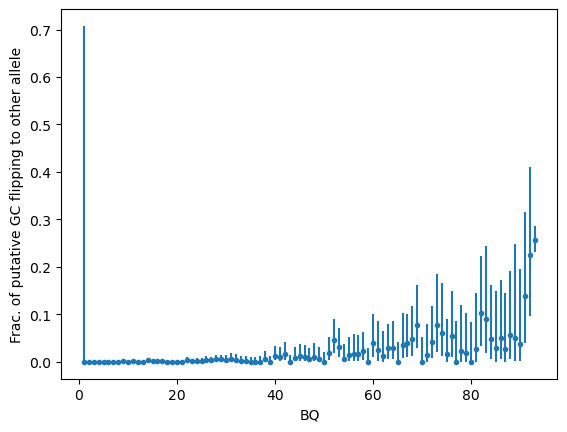

In [10]:
import statsmodels.stats.proportion

A = putative_gc_df_hap_cnt["x_vs_y/x"]
B = putative_gc_df_hap_cnt["x_vs_y/x"] + putative_gc_df_hap_cnt["x_vs_y/z"] + putative_gc_df_hap_cnt["x_vs_y/y"]
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["qual_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("BQ");
plt.ylabel("Frac. of putative GC flipping to other allele");
#plt.ylim(0,1);


/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/statsmodels/stats/proportion.py:191: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a


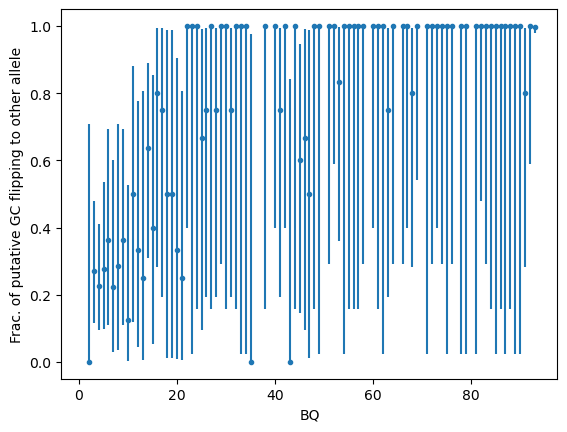

In [11]:
import statsmodels.stats.proportion

A = putative_gc_df_hap_cnt["x_vs_y/x"]
B = putative_gc_df_hap_cnt["x_vs_y/x"] + putative_gc_df_hap_cnt["x_vs_y/z"] 
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["qual_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("BQ");
plt.ylabel("Frac. of putative GC flipping to other allele");
#plt.ylim(0,1);


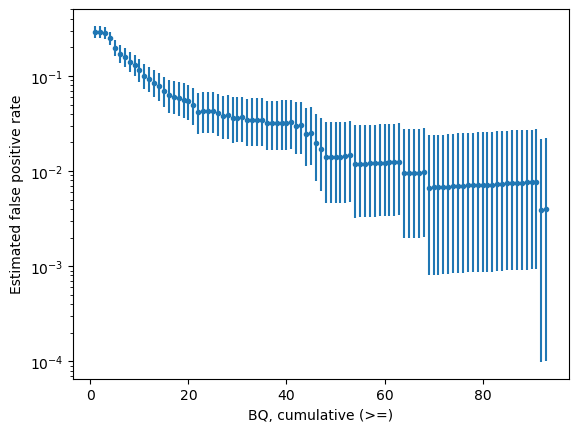

In [12]:
import statsmodels.stats.proportion

A = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/z"][::-1])[::-1]
B = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/x"][::-1])[::-1]
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["qual_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("BQ, cumulative (>=)");
plt.ylabel("Estimated false positive rate");
plt.yscale("log")
#plt.ylim(0.95,1);


# BQ as distance from start/end of read

## Read length

In [13]:
def get_read_lengths(focal_sample_id, denovo_chrom):
    filtered_high_conf_mismatches_df = pl.scan_parquet(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.high_confindence_snps.parquet")

    read_lengths = filtered_high_conf_mismatches_df.unique(["read_name"]).select("read_length1")

    read_lengths = read_lengths.collect(streaming=True)
    
    return read_lengths


Mean: 13389.531224052722
Median: 12880.0
SE: 2528.67291504643
Quantiles 1%, 5%, 95%, 99%: [ 9491. 10253. 18273. 20564.]


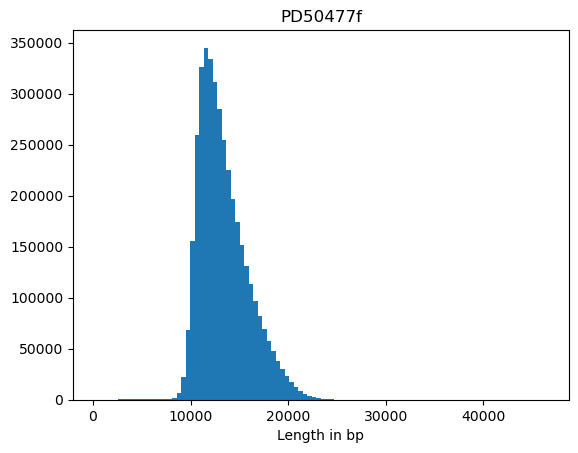

In [14]:
sample_id = "PD50477f"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

Mean: 11167.930837191574
Median: 9842.0
SE: 5924.526666056847
Quantiles 1%, 5%, 95%, 99%: [ 3111.  4164. 22328. 27528.]


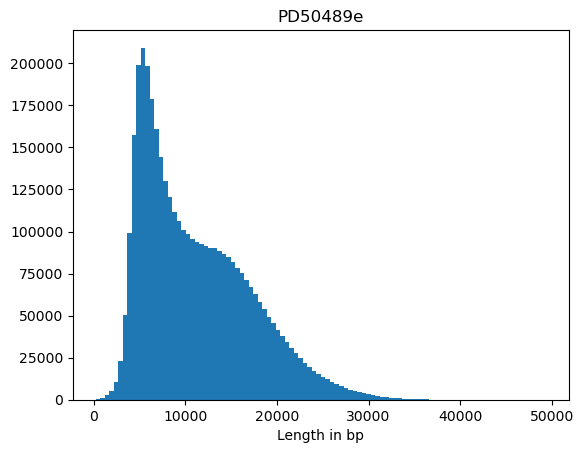

In [15]:
sample_id = "PD50489e"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

Mean: 15774.61626825934
Median: 15066.0
SE: 3691.9200139684485
Quantiles 1%, 5%, 95%, 99%: [10308. 11206. 22951. 26521.]


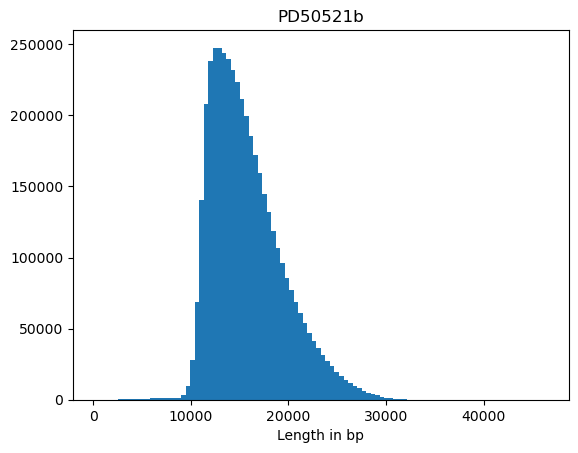

In [16]:
sample_id = "PD50521b"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

Mean: 13953.353433735514
Median: 13346.0
SE: 3717.556910772088
Quantiles 1%, 5%, 95%, 99%: [ 6291.  9246. 21045. 24452.]


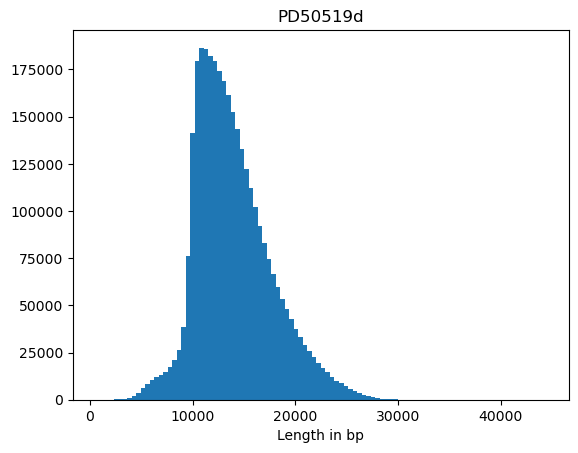

In [17]:
sample_id = "PD50519d"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

Mean: 16865.565756623168
Median: 16128.0
SE: 3213.3479747256915
Quantiles 1%, 5%, 95%, 99%: [12442. 13121. 23247. 26779.]


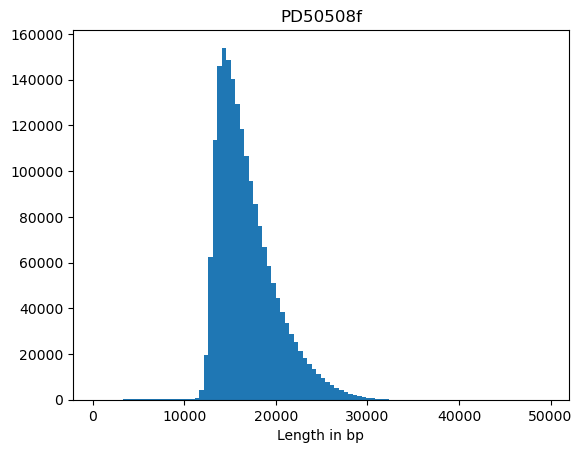

In [18]:
sample_id = "PD50508f"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

Mean: 15480.855215232064
Median: 14769.0
SE: 3428.626928259904
Quantiles 1%, 5%, 95%, 99%: [10240. 11258. 22188. 25377.]


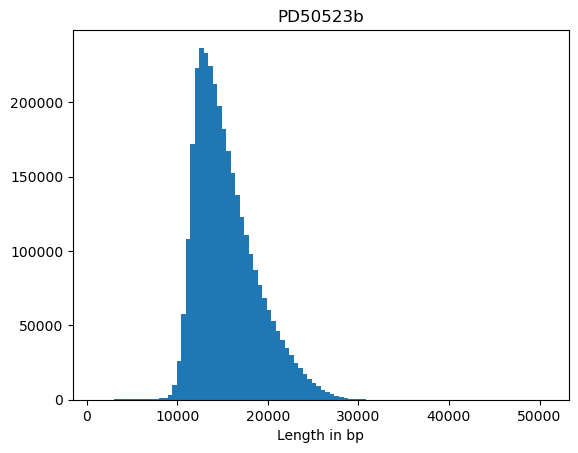

In [19]:
sample_id = "PD50523b"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

Mean: 16310.997231757863
Median: 15643.0
SE: 3638.3431145334835
Quantiles 1%, 5%, 95%, 99%: [10699. 11668. 23338. 26614.]


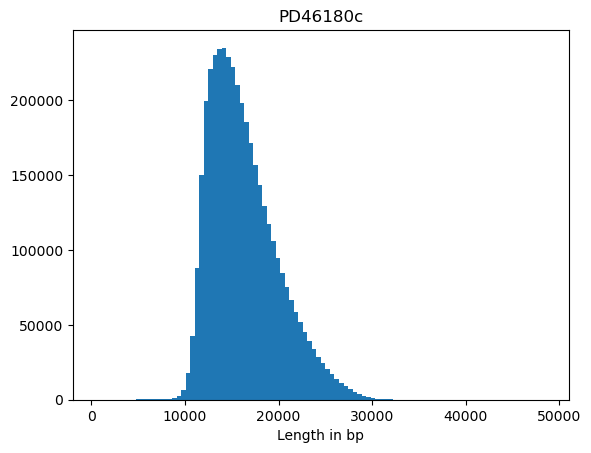

In [20]:
sample_id = "PD46180c"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

Mean: 12232.141218814977
Median: 11347.0
SE: 4322.444099146669
Quantiles 1%, 5%, 95%, 99%: [ 5247.    6893.   20602.   25118.33]


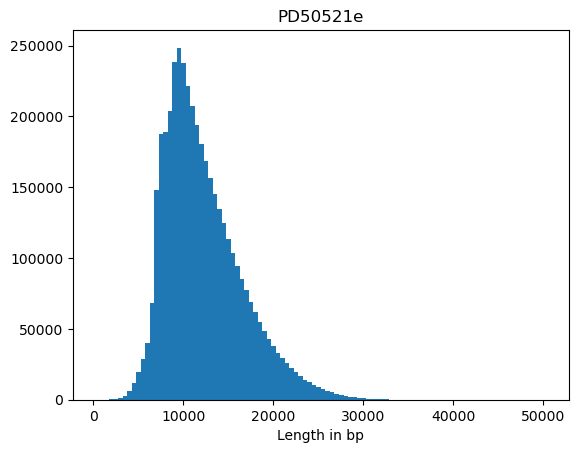

In [21]:
sample_id = "PD50521e"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

Mean: 15654.761185300998
Median: 15071.0
SE: 3022.469406791174
Quantiles 1%, 5%, 95%, 99%: [10900. 11826. 21537. 24344.]


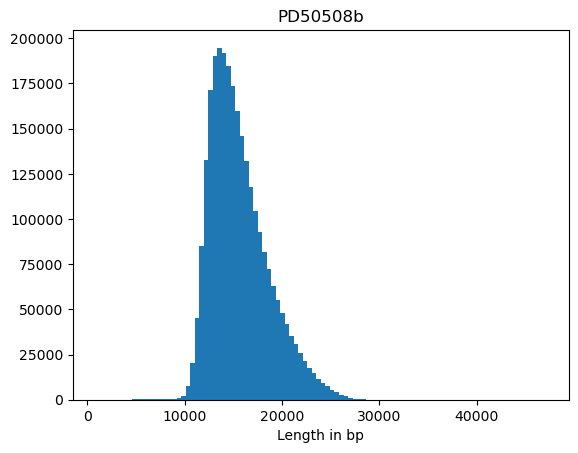

In [22]:
sample_id = "PD50508b"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

## Errors at read ends

In [23]:
def do_it_all_start(focal_sample_id, denovo_chrom):
    filtered_high_conf_mismatches_df = pl.scan_parquet(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.high_confindence_snps.parquet")
    
    
    filtered_high_conf_mismatches_df = diagnostics.add_high_confidence_annotation(
        filtered_high_conf_mismatches_df,
        base_qual_min = 0, # Don't filter on this just yet
    )
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.filter("is_high_conf_event")
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.collect(streaming=True)
    
    #
    # 3. Find mismatches supported by flanking high conf SNPs (putative GC)
    #
    def F(df):
        df = (df
            .with_columns(
                pl.col("fits1").cum_sum().alias("fits1_before"),
                pl.col("fits1").cum_sum(reverse=True).alias("fits1_after"),
                pl.col("fits2").cum_sum().alias("fits2_before"),
                pl.col("fits2").cum_sum(reverse=True).alias("fits2_after"),
                pl.col("start").cum_count().alias("snp_index"),
                pl.col("start").cum_count(reverse=True).alias("snp_rev_index"),
            )
        )
        return df

    min_mapq = 93
    context_df = (filtered_high_conf_mismatches_df
        .filter((pl.col("qual_start1") >= min_mapq) & (pl.col("qual_start2") >= min_mapq))
        .with_columns(
            (pl.col("op1") == 7).alias("fits1").cast(int),
            (pl.col("op2") == 7).alias("fits2").cast(int),
        )
        .sort("start")
        .group_by("read_name")    
        .map_groups(F)
    )

    #
    # 4. Calculate stats
    # 
    flanking = 3       # including itself, if it fits

    # Filter for putative GC events
    putative_gc_df_hap = pl.concat(
        [
            (context_df
                .filter((pl.col("op1") == 8) & (pl.col("snp_index") == 0) & (pl.col("fits1_after") >= flanking))
                .with_columns((pl.col("op2") == 7).alias("other_op_equal"))
                .with_columns(pl.col("start").alias("dist_from_end"))
            ),
            (context_df
                .filter((pl.col("op1") == 8) & (pl.col("snp_rev_index") == 0) & (pl.col("fits1_before") >= flanking))
                .with_columns((pl.col("op2") == 7).alias("other_op_equal"))
                .with_columns((pl.col("read_length1") - pl.col("end")).alias("dist_from_end"))
            ),
            (context_df
                .filter((pl.col("op2") == 8) & (pl.col("snp_index") == 0) & (pl.col("fits2_after") >= flanking))
                .with_columns((pl.col("op1") == 7).alias("other_op_equal"))
                .with_columns(pl.col("start").alias("dist_from_end"))
            ),
            (context_df
                .filter((pl.col("op2") == 8) & (pl.col("snp_rev_index") == 0) & (pl.col("fits2_before") >= flanking))
                .with_columns((pl.col("op1") == 7).alias("other_op_equal"))
                .with_columns((pl.col("read_length2") - pl.col("end")).alias("dist_from_end"))
            ),
        ]
    )

    # Mark where there are two different SNPs
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns((pl.col("refseq_start1") != pl.col("refseq_start2")).alias("diff_in_haplotypes"))
    )

    # Make the three categories
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns(
            pl.when(pl.col('diff_in_haplotypes') & pl.col("other_op_equal")).then(pl.lit("x_vs_y/x"))
              .when(pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/z"))
              .when(~pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/y"))
              .otherwise(pl.lit("x_vs_x/x"))
              .alias('category')
        )
    )
    
    to_round = 50
    putative_gc_df_hap_cnt = (putative_gc_df_hap
        .with_columns(
            (pl.col("dist_from_end") // to_round * to_round).alias("dist_from_end_rounded"),
        )
        .group_by(["dist_from_end_rounded", "category"])
        .count()
        .pivot(
            values=["count"],
            index=["dist_from_end_rounded"],
            columns=["category"],
            aggregate_function="sum",
        )
        .fill_null(0)
        .sort("dist_from_end_rounded")
        .with_columns(
            pl.lit(focal_sample_id).alias("focal_sample_id"),
            pl.lit(denovo_chrom).alias("chrom"),
        )
    )
    
    return putative_gc_df_hap_cnt

In [24]:
%%time 
startdfs = joblib.Parallel(n_jobs=4, verbose=50)(
    joblib.delayed(do_it_all_start)(focal_sample_id, chrom + "_RagTag") for chrom in aut_chrom_names
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.9min


/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  5.7min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  5.8min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done  16 out of  22 | elapsed:  5.9min remaining:  2.2min
[Parallel(n_jobs=4)]: Done  17 out of  22 | elapsed:  6.3min remai

In [25]:
for i in range(len(startdfs)):
    if "x_vs_y/z" not in startdfs[i].columns:
        startdfs[i] = startdfs[i].with_columns(pl.lit(0).alias("x_vs_y/z"))

In [26]:
%%time
putative_gc_df_hap_cnt = (
    pl.concat([x[["dist_from_end_rounded", "x_vs_y/y", "x_vs_y/x", "x_vs_y/z"]] for x in startdfs], how="vertical_relaxed")
    .group_by(["dist_from_end_rounded"])
    .agg(pl.col("x_vs_y/y").sum(), pl.col("x_vs_y/x").sum(), pl.col("x_vs_y/z").sum())
    .sort("dist_from_end_rounded")
)



CPU times: user 1.36 ms, sys: 345 µs, total: 1.7 ms
Wall time: 927 µs


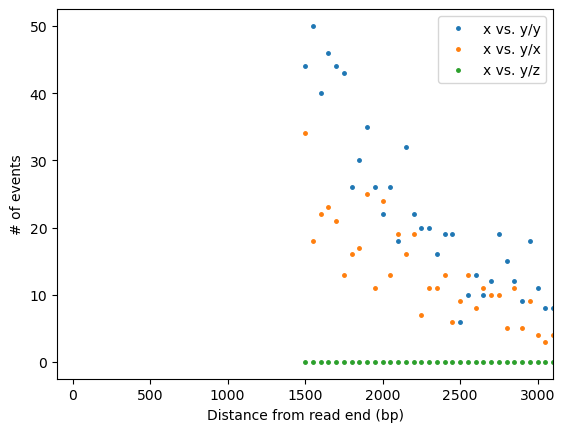

In [27]:
import statsmodels.stats.proportion

plt.plot(
    putative_gc_df_hap_cnt["dist_from_end_rounded"],
    putative_gc_df_hap_cnt["x_vs_y/y"],
    '.',
    ms=5,
    label="x vs. y/y",
)

plt.plot(
    putative_gc_df_hap_cnt["dist_from_end_rounded"],
    putative_gc_df_hap_cnt["x_vs_y/x"],
    '.',
    ms=5,
    label="x vs. y/x",
)

plt.plot(
    putative_gc_df_hap_cnt["dist_from_end_rounded"],
    putative_gc_df_hap_cnt["x_vs_y/z"],
    '.',
    ms=5,
    label="x vs. y/z",
)


plt.xlabel("Distance from read end (bp)");
plt.ylabel("# of events");
#plt.yscale("log")
plt.xlim(-100, 3100);
plt.legend();


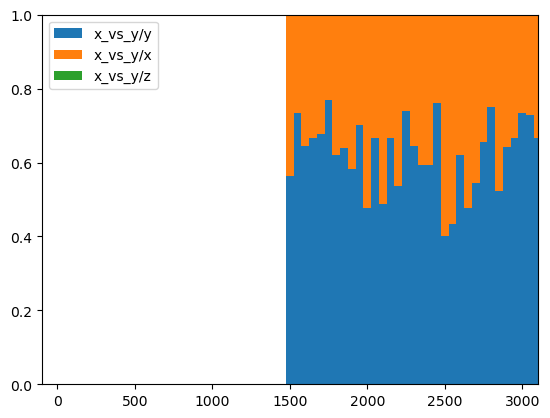

In [28]:
# Sample data (replace this with your matrix)
data = np.array([
    putative_gc_df_hap_cnt["x_vs_y/y"],
    putative_gc_df_hap_cnt["x_vs_y/x"],
    putative_gc_df_hap_cnt["x_vs_y/z"]
]).T.astype(float)

data /= data.sum(axis=1)[:,np.newaxis]

# Number of rows and columns in the matrix
num_rows, num_cols = data.shape

# # Initialize a color map for better visualization
# colors = plt.cm.viridis(np.linspace(0, 1, num_cols))

# Plotting the stacked bars
fig, ax = plt.subplots()

for i in range(num_cols):
    bottom = np.sum(data[:,:i], axis=1)
    ax.bar(putative_gc_df_hap_cnt["dist_from_end_rounded"].to_numpy(), data[:,i], bottom=bottom, width=50)
    

# Adding labels and legend
ax.legend(["x_vs_y/y", "x_vs_y/x", "x_vs_y/z"])
ax.set_xlim(-100,3100);

# Show the plot
plt.show()


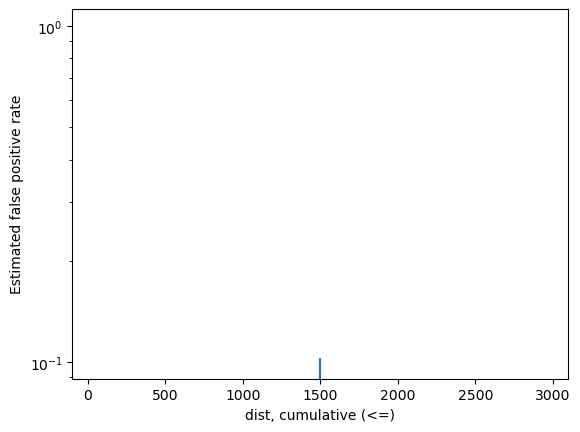

In [29]:
import statsmodels.stats.proportion

A = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/z"])
B = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/x"])
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["dist_from_end_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("dist, cumulative (<=)");
plt.ylabel("Estimated false positive rate");
plt.yscale("log")
plt.xlim(-100, 3100);
